# Importing required libraries

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import math
from numpy import argmax
import sys
from IPython.display import display
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import numpy as np
import time
import statistics

# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [2]:
# Monte Carlo Dropout Layer
class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Read in the Train and Test data

In [4]:
X_train = np.array(pd.read_parquet('data/X_train.parquet').drop(['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'], axis=1)).astype('float')
X_test = np.array(pd.read_parquet('data/X_test.parquet').drop(['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'], axis=1)).astype('float')

y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'])
y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'])                        
#y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
#y_train_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
y_test_reg = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv']).astype('float')
y_train_reg = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv']).astype('float')

# Check Data before Modelling 

In [10]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Regression Shape:', y_train_reg.shape)
print('Testing Labels Regression Shape:', y_test_reg.shape)

Training Features Shape: (111791, 175)
Testing Features Shape: (27948, 175)
Training Labels Regression Shape: (111791,)
Testing Labels Regression Shape: (27948,)


# Hyperparameter Tuning

In [12]:
def model_builder(hp):
    model = keras.Sequential()

    # layer 01
    layer_01 = hp.Choice('layer_01', values = ['False','True'])
    if layer_01:
        units_01 = hp.Int('units_01', min_value=64, max_value=1024, step=32)
        activation_01 = hp.Choice('activation_01', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_01 = hp.Choice('kernel_01', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_01, activation = activation_01, kernel_initializer=kernel_initializer_01, input_shape = (X_train.shape[1],)))
    
    batch_01 = hp.Choice('batch_01', values = ['False','True'])
    if batch_01:
        model.add(BatchNormalization())
    
    drop_01 = hp.Choice('drop_01', values = ['False','drop','Monte'])
    if drop_01 == 'drop':
        dropout_01 = hp.Float('dropout_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_01))
    elif drop_01 == 'Monte':
        monte_01 = hp.Float('monte_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_01))
    
    # layer 02
    layer_02 = hp.Choice('layer_02', values = ['False','True'])
    if layer_02:
        units_02 = hp.Int('units_02', min_value = 32, max_value = 512, step=32)
        activation_02 = hp.Choice('activation_02', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_02 = hp.Choice('kernel_02', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_02, activation = activation_02, kernel_initializer=kernel_initializer_02))
    
    batch_02 = hp.Choice('batch_02', values = ['False','True'])
    if batch_02:
        model.add(BatchNormalization())
        
    drop_02 = hp.Choice('drop_02', values = ['False','drop','Monte'])
    if drop_02:
        dropout_02 = hp.Float('dropout_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_02))
    elif drop_02 == 'Monte':
        monte_02 = hp.Float('monte_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_02))
    
    # layer 03
    layer_03 = hp.Choice('layer_03', values = ['False','True'])
    if layer_03:
        units_03 = hp.Int('units_03', min_value = 32, max_value = 512, step=32)
        activation_03 = hp.Choice('activation_03', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_03 = hp.Choice('kernel_03', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_03, activation = activation_03, kernel_initializer=kernel_initializer_03))
    
    drop_03 = hp.Choice('drop_03', values = ['False','drop','Monte'])
    if drop_03:
        dropout_03 = hp.Float('dropout_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_03))
    elif drop_03 == 'Monte':
        monte_03 = hp.Float('monte_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_03))
    
    batch_03 = hp.Choice('batch_03', values = ['False','True'])
    if batch_03:
        model.add(BatchNormalization())
    
    # layer 04
    layer_04 = hp.Choice('layer_04', values = ['False','True'])
    if layer_04:
        units_04 = hp.Int('units_04', min_value = 16, max_value = 512, step=32)
        activation_04 = hp.Choice('activation_04', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_04 = hp.Choice('kernel_04', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_04, activation = activation_04, kernel_initializer=kernel_initializer_04))
    
    drop_04 = hp.Choice('drop_04', values = ['False','drop','Monte'])
    if drop_04:
        dropout_04 = hp.Float('dropout_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_04))
    elif drop_04 == 'Monte':
        monte_04 = hp.Float('monte_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_04))
        
    batch_04 = hp.Choice('batch_04', values = ['False','True'])
    if batch_04:
        model.add(BatchNormalization())
    
    # layer 05
    layer_05 = hp.Choice('layer_05', values = ['False','True'])
    if layer_05:
        units_05 = hp.Int('units_05', min_value = 16, max_value = 256, step=32)
        activation_05 = hp.Choice('activation_05', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_05 = hp.Choice('kernel_05', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_05, activation = activation_05, kernel_initializer=kernel_initializer_05))
    
    drop_05 = hp.Choice('drop_05', values = ['False','drop','Monte'])
    if drop_05:
        dropout_05 = hp.Float('dropout_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_05))
    elif drop_05 == 'Monte':
        monte_05 = hp.Float('monte_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_05))
        
    batch_05 = hp.Choice('batch_05', values = ['False','True'])
    if batch_05:
        model.add(BatchNormalization())
    
    # layer 06
    layer_06 = hp.Choice('layer_06', values = ['False','True'])
    if layer_06:
        units_06 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_06 = hp.Choice('activation_06', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_06 = hp.Choice('kernel_06', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_06, activation = activation_06, kernel_initializer=kernel_initializer_06))
        
    # layer 07
    layer_07 = hp.Choice('layer_07', values = ['False','True'])
    if layer_07:
        units_07 = hp.Int('units_07', min_value = 4, max_value = 16, step=4)
        activation_07 = hp.Choice('activation_07', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_07 = hp.Choice('kernel_07', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_07, activation = activation_07, kernel_initializer=kernel_initializer_07))    
    
    # layer 08
    layer_08 = hp.Choice('layer_08', values = ['False','True'])
    if layer_08:
        units_08 = hp.Int('units_08', min_value = 4, max_value = 16, step=4)
        activation_08 = hp.Choice('activation_08', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_08 = hp.Choice('kernel_08', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_08, activation = activation_08, kernel_initializer=kernel_initializer_08))
        
    # layer 09
    layer_09 = hp.Choice('layer_06', values = ['False','True'])
    if layer_09:
        units_09 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_09 = hp.Choice('activation_09', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_09 = hp.Choice('kernel_09', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_09, activation = activation_09, kernel_initializer=kernel_initializer_09))
        
    # layer 10
    layer_10 = hp.Choice('layer_10', values = ['False','True'])
    if layer_10:
        units_10 = hp.Int('units_10', min_value = 4, max_value = 16, step=4)
        activation_10 = hp.Choice('activation_10', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_10 = hp.Choice('kernel_10', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_10, activation = activation_10, kernel_initializer=kernel_initializer_10))
    
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mse', metrics = ['mse', 'mae',rmse,'mape','msle'])

    return model

In [13]:
# Select Tuner Hyperband
tuner = kt.Hyperband(model_builder,
                     objective = 'mse',
                     max_epochs = 40,
                     factor = 6,
                     project_name = 'MLP_Regression_withoutTA_01')

stop_early = callbacks.EarlyStopping(monitor='loss', patience=7)

INFO:tensorflow:Reloading Oracle from existing project ./MLP_Regression_withoutTA_01/oracle.json
INFO:tensorflow:Reloading Tuner from ./MLP_Regression_withoutTA_01/tuner0.json


In [14]:
tuner.search(X_train, y_train_reg, epochs=100, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal model is:')
print(best_hps)

Trial 77 Complete [00h 10m 48s]
mse: 801.6405639648438

Best mse So Far: 423.8593444824219
Total elapsed time: 02h 06m 07s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal model is:


In [15]:
tuner.results_summary()

Results summary
Results in ./MLP_Regression_withoutTA_01
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
layer_01: False
units_01: 896
activation_01: relu
kernel_01: he_normal
batch_01: True
drop_01: False
layer_02: True
units_02: 416
activation_02: tanh
kernel_02: glorot_normal
batch_02: False
drop_02: drop
dropout_02: 0.2
layer_03: False
units_03: 416
activation_03: relu
kernel_03: he_uniform
drop_03: False
dropout_03: 0.4
batch_03: False
layer_04: False
units_04: 496
activation_04: LeakyReLU
kernel_04: he_normal
drop_04: drop
dropout_04: 0.5
batch_04: True
layer_05: False
units_05: 240
activation_05: relu
kernel_05: he_uniform
drop_05: Monte
dropout_05: 0.5
batch_05: True
layer_06: False
units_06: 8
activation_06: LeakyReLU
kernel_06: he_normal
layer_07: False
units_07: 12
activation_07: relu
kernel_07: glorot_uniform
layer_08: False
units_08: 16
activation_08: relu
kernel_08: he_normal
activation_09: LeakyReLU
kernel_09: he_uniform
layer

learning_rate: 0.001
dropout_01: 0.4
monte_01: 0.1
tuner/epochs: 7
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: b5f926a6e1dbfd0826e7fc5c5d104bb7
Score: 809.301025390625


In [16]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_reg,validation_split=0.33, epochs = 100)

Epoch 1/100
2341/2341 [==============================] - 26s 11ms/step - loss: 1616.7339 - mse: 1616.7339 - mae: 20.4816 - rmse: 20.4816 - mape: 132.7793 - msle: 3.2697 - val_loss: 824.0266 - val_mse: 824.0266 - val_mae: 15.2176 - val_rmse: 15.2176 - val_mape: 178.2948 - val_msle: 0.9688
Epoch 2/100
2341/2341 [==============================] - 25s 10ms/step - loss: 865.6868 - mse: 865.6868 - mae: 16.5440 - rmse: 16.5440 - mape: 191.3169 - msle: 1.0292 - val_loss: 830.1734 - val_mse: 830.1734 - val_mae: 15.2885 - val_rmse: 15.2885 - val_mape: 183.0842 - val_msle: 0.9344
Epoch 3/100
2341/2341 [==============================] - 24s 10ms/step - loss: 831.5903 - mse: 831.5903 - mae: 16.1370 - rmse: 16.1370 - mape: 186.2343 - msle: 0.9627 - val_loss: 848.4020 - val_mse: 848.4020 - val_mae: 15.6854 - val_rmse: 15.6854 - val_mape: 193.4944 - val_msle: 0.9368
Epoch 4/100
2341/2341 [==============================] - 24s 10ms/step - loss: 808.6732 - mse: 808.6732 - mae: 15.8388 - rmse: 15.8388 - 

2341/2341 [==============================] - 24s 10ms/step - loss: 433.3617 - mse: 433.3617 - mae: 11.2704 - rmse: 11.2704 - mape: 159.6928 - msle: 0.7006 - val_loss: 891.0985 - val_mse: 891.0985 - val_mae: 15.1317 - val_rmse: 15.1317 - val_mape: 159.3161 - val_msle: 0.7717
Epoch 30/100
2341/2341 [==============================] - 24s 10ms/step - loss: 428.8064 - mse: 428.8064 - mae: 11.2072 - rmse: 11.2072 - mape: 159.9877 - msle: 0.6988 - val_loss: 902.0456 - val_mse: 902.0456 - val_mae: 15.1083 - val_rmse: 15.1083 - val_mape: 158.5343 - val_msle: 0.7678
Epoch 31/100
2341/2341 [==============================] - 24s 10ms/step - loss: 414.3491 - mse: 414.3491 - mae: 11.0620 - rmse: 11.0620 - mape: 157.6990 - msle: 0.6903 - val_loss: 907.6530 - val_mse: 907.6530 - val_mae: 15.0389 - val_rmse: 15.0389 - val_mape: 155.8171 - val_msle: 0.7593
Epoch 32/100
2341/2341 [==============================] - 24s 10ms/step - loss: 406.2645 - mse: 406.2645 - mae: 10.9212 - rmse: 10.9212 - mape: 156.9

Epoch 58/100
2341/2341 [==============================] - 24s 10ms/step - loss: 285.4099 - mse: 285.4099 - mae: 9.2425 - rmse: 9.2425 - mape: 141.0457 - msle: 0.6052 - val_loss: 926.1995 - val_mse: 926.1995 - val_mae: 14.8783 - val_rmse: 14.8783 - val_mape: 144.3953 - val_msle: 0.7405
Epoch 59/100
2341/2341 [==============================] - 24s 10ms/step - loss: 278.1662 - mse: 278.1662 - mae: 9.1552 - rmse: 9.1552 - mape: 139.4513 - msle: 0.5985 - val_loss: 917.8986 - val_mse: 917.8986 - val_mae: 14.8923 - val_rmse: 14.8923 - val_mape: 151.4903 - val_msle: 0.7499
Epoch 60/100
2341/2341 [==============================] - 24s 10ms/step - loss: 279.5568 - mse: 279.5568 - mae: 9.1373 - rmse: 9.1373 - mape: 140.0564 - msle: 0.6003 - val_loss: 922.4724 - val_mse: 922.4724 - val_mae: 15.0571 - val_rmse: 15.0571 - val_mape: 154.8180 - val_msle: 0.7635
Epoch 61/100
2341/2341 [==============================] - 24s 10ms/step - loss: 279.5273 - mse: 279.5273 - mae: 9.1384 - rmse: 9.1384 - mape: 

Epoch 87/100
2341/2341 [==============================] - 24s 10ms/step - loss: 218.7331 - mse: 218.7331 - mae: 8.2122 - rmse: 8.2122 - mape: 129.1094 - msle: 0.5449 - val_loss: 914.8359 - val_mse: 914.8359 - val_mae: 14.8246 - val_rmse: 14.8246 - val_mape: 141.5201 - val_msle: 0.7226
Epoch 88/100
2341/2341 [==============================] - 24s 10ms/step - loss: 220.6861 - mse: 220.6861 - mae: 8.2243 - rmse: 8.2243 - mape: 127.2467 - msle: 0.5395 - val_loss: 940.5794 - val_mse: 940.5794 - val_mae: 15.3328 - val_rmse: 15.3328 - val_mape: 157.6597 - val_msle: 0.7800
Epoch 89/100
2341/2341 [==============================] - 24s 10ms/step - loss: 217.0878 - mse: 217.0878 - mae: 8.1546 - rmse: 8.1546 - mape: 128.7192 - msle: 0.5389 - val_loss: 914.0556 - val_mse: 914.0556 - val_mae: 14.7283 - val_rmse: 14.7283 - val_mape: 141.7852 - val_msle: 0.7249
Epoch 90/100
2341/2341 [==============================] - 24s 10ms/step - loss: 213.8748 - mse: 213.8748 - mae: 8.1179 - rmse: 8.1179 - mape: 

In [17]:
val_loss_per_epoch = history.history['val_mse']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 5


In [18]:
start_time = time.time()
hypermodel = tuner.hypermodel.build(best_hps)
print(str(model),"--- %s seconds ---" % ((time.time() - start_time)))

# Retrain the model
history = hypermodel.fit(X_train, y_train_reg,validation_split=0.33, epochs=best_epoch)

<keras.engine.sequential.Sequential object at 0x7fd01c66e940> --- 0.1766362190246582 seconds ---
Epoch 1/5
2341/2341 [==============================] - 26s 10ms/step - loss: 1180.8049 - mse: 1180.8049 - mae: 17.9643 - rmse: 17.9643 - mape: 140.8212 - msle: 1.7608 - val_loss: 823.1108 - val_mse: 823.1108 - val_mae: 14.6613 - val_rmse: 14.6613 - val_mape: 172.0733 - val_msle: 0.8796
Epoch 2/5
2341/2341 [==============================] - 24s 10ms/step - loss: 857.7041 - mse: 857.7041 - mae: 16.3672 - rmse: 16.3672 - mape: 191.9323 - msle: 0.9604 - val_loss: 832.7917 - val_mse: 832.7917 - val_mae: 14.6752 - val_rmse: 14.6752 - val_mape: 166.7964 - val_msle: 0.8129
Epoch 3/5
2341/2341 [==============================] - 24s 10ms/step - loss: 831.2122 - mse: 831.2122 - mae: 16.1437 - rmse: 16.1437 - mape: 196.6508 - msle: 0.9366 - val_loss: 820.5129 - val_mse: 820.5129 - val_mae: 14.9591 - val_rmse: 14.9591 - val_mape: 186.5607 - val_msle: 0.8663
Epoch 4/5
2341/2341 [=========================

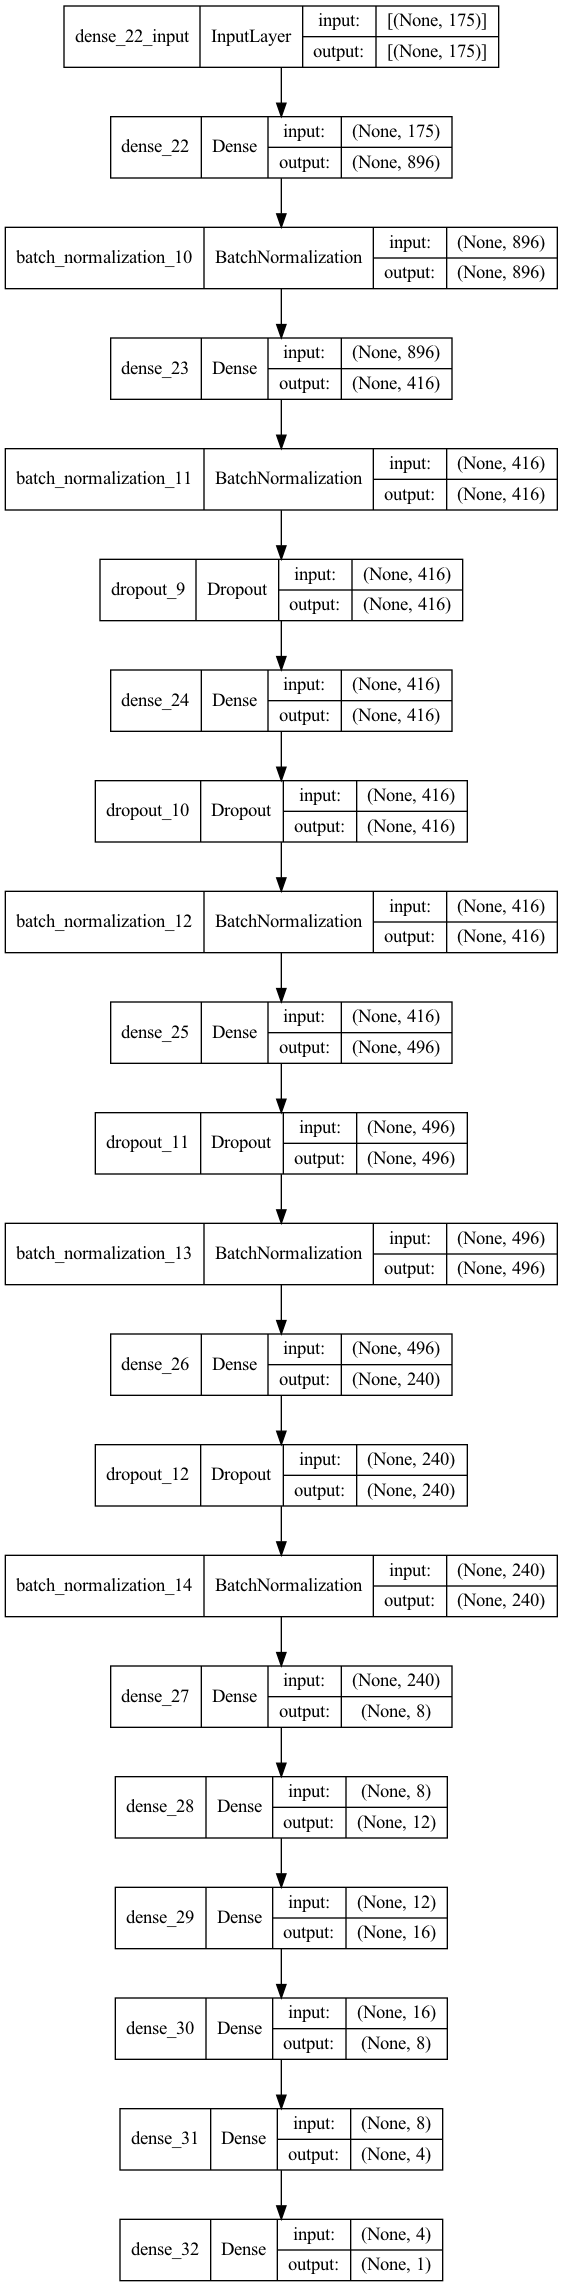

In [19]:
# Print Model Layout:
plot_model(hypermodel, to_file='results/hypermodel_reg_withoutTA.png', show_shapes=True)

In [20]:
eval_result = hypermodel.evaluate(X_test, y_test_reg)
print("[loss, MSE, MAE, RMSE, MAPE, MSLE]:", eval_result)

874/874 [==============================] - 2s 3ms/step - loss: 857.5382 - mse: 857.5382 - mae: 15.5583 - rmse: 15.5583 - mape: 184.5026 - msle: 0.8640
[loss, MSE, MAE, RMSE, MAPE, MSLE]: [857.5382080078125, 857.5382080078125, 15.55833625793457, 15.55833625793457, 184.5026092529297, 0.8639525175094604]


# 10-Fold Cross-Validation

In [21]:
# Define the K-fold Cross Validator

if cross_validation:

    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    loss_per_fold = []
    MAE_per_fold = []

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train_reg, y_test_reg), axis=0)

    for train, test in kfold.split(inputs, targets):

        best_model = tuner.hypermodel.build(best_hps)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        best_model.fit(inputs[train], targets[train], epochs=best_epoch, verbose=0, callbacks = [stop_early])
        score = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {score}')

        yhat = model.predict(inputs[test])
        print('MAE: %.3f' % mean_absolute_error(targets[test], yhat))

        MAE_per_fold.append(mean_absolute_error(targets[test], yhat))
        loss_per_fold.append(score)

        # Increase fold number
        fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: [508.4271545410156, 508.4271545410156, 10.471978187561035, 10.471978187561035, 130.08595275878906, 0.5937464833259583]
MAE: 10.472
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: [516.9405517578125, 516.9405517578125, 10.694659233093262, 10.694659233093262, 130.7281951904297, 0.5857988595962524]
MAE: 10.695
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: [484.8141784667969, 484.8141784667969, 10.364957809448242, 10.364957809448242, 129.02236938476562, 0.5851043462753296]
MAE: 10.365
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: [463.2254943847656, 463.2254943847656, 10.245028495788574, 10.245028495788574, 131.53138732910156, 0.5911175012588501]
MAE: 10.245
-----------------

In [22]:
loss = []
mse = []
mae = []
rmse = []
mape = []
msle = []
for i in range(len(loss_per_fold)):
    loss.append(loss_per_fold[i][0])
    mse.append(loss_per_fold[i][1])
    mae.append(loss_per_fold[i][2])
    rmse.append(loss_per_fold[i][3])
    mape.append(loss_per_fold[i][4])
    msle.append(loss_per_fold[i][5])

In [23]:
print("Mean Loss: %s" % statistics.mean(loss))
print("Mean MSE: %s" % statistics.mean(mse))
print("Mean MAE: %s" % statistics.mean(mae))
print("Mean RMSE: %s" % statistics.mean(rmse))
print("Mean MAPE: %s" % statistics.mean(mape))
print("Mean MSLE: %s" % statistics.mean(msle))

Mean Loss: 502.75091552734375
Mean MSE: 502.75091552734375
Mean MAE: 10.490931701660156
Mean RMSE: 10.490931701660156
Mean MAPE: 129.84518508911134
Mean MSLE: 0.5895962715148926


In [24]:
print("SD Loss: %s" % statistics.stdev(loss))
print("SD MSE: %s" % statistics.stdev(mse))
print("SD MAE: %s" % statistics.stdev(mae))
print("SD RMSE: %s" % statistics.stdev(rmse))
print("SD MAPE: %s" % statistics.stdev(mape))
print("SD MSLE: %s" % statistics.stdev(msle))

SD Loss: 24.711319280891527
SD MSE: 24.711319280891527
SD MAE: 0.19309143498943462
SD RMSE: 0.19309143498943462
SD MAPE: 1.4715337286735715
SD MSLE: 0.009463853629101507


# Plot Results

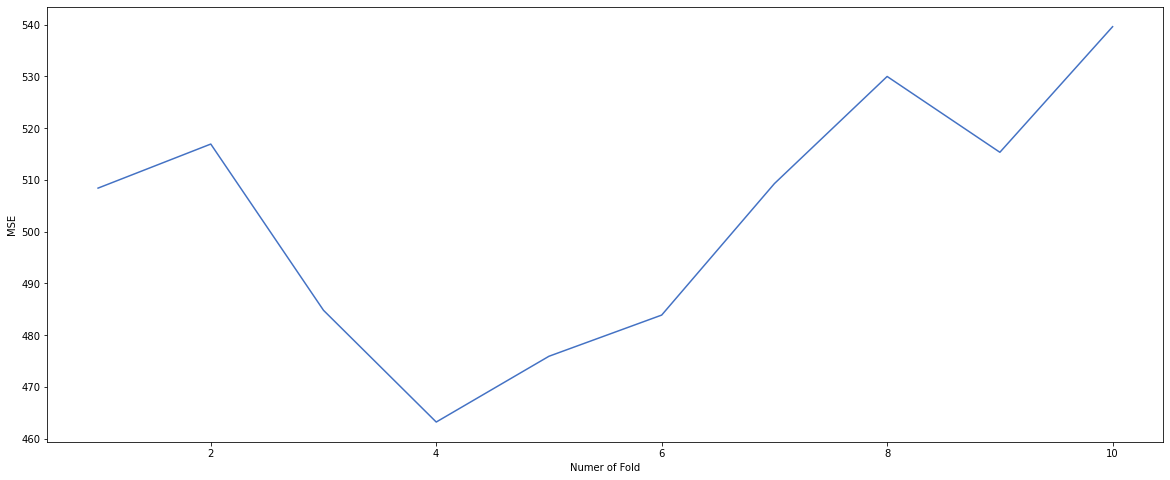

In [25]:
plt.figure(figsize=(20, 8))
#Create the plots
plt.plot(range(1,len(loss)+1),loss, color = '#4472C4', label = 'MSE')
#plt.plot(range(1,len(mape)+1),mape, color='red', label = 'MAPE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MSE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MSE_withoutTA.png')
plt.rcParams.update({'font.size': 12})

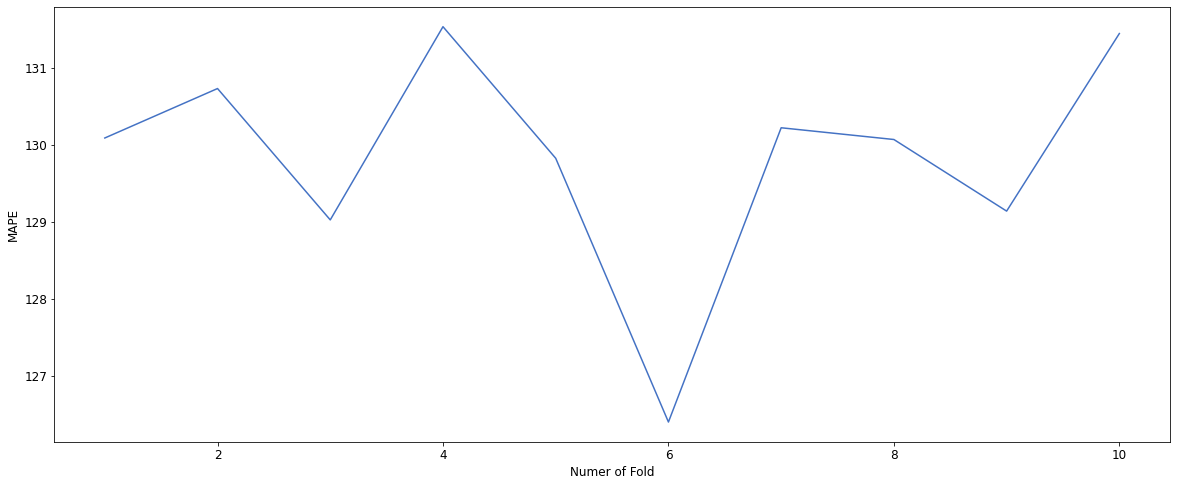

In [26]:
plt.figure(figsize=(20, 8))
#Create the plots
#plt.plot(range(1,len(loss)+1),loss, color='blue', label = 'MSE')
plt.plot(range(1,len(mape)+1),mape, color = '#4472C4', label = 'MAPE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MAPE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MAPE_withoutTA.png')
plt.rcParams.update({'font.size': 12})

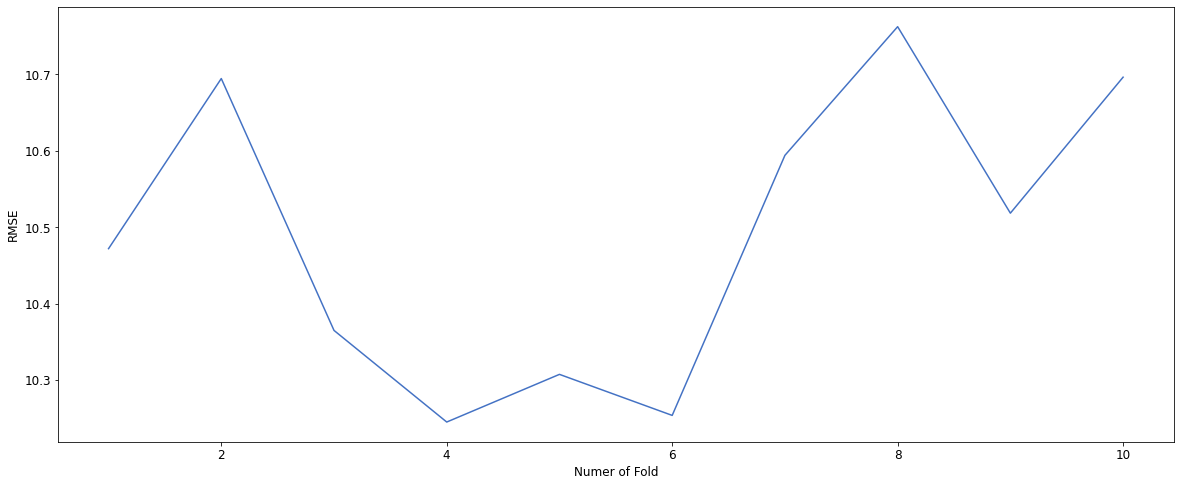

In [27]:
plt.figure(figsize=(20, 8))
#Create the plots
#plt.plot(range(1,len(MAE_per_fold)+1),MAE_per_fold, color='blue', label = 'MAE')
plt.plot(range(1,len(rmse)+1),rmse, color = '#4472C4', label = 'RMSE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('RMSE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_RMSE_withoutTA.png')
plt.rcParams.update({'font.size': 12})